Maybe you have had this experience. You want to make a nice `pcolor` or surface plot of a 2D function or dataset over space ($(x, y)$ coordinates). *But*:

- `pcolor`, `contour` or `surface_plot` need inputs in meshgrid form `(X, Y, Z)`
- Your data is in a different form, e.g.
     + the function takes coordinates in vector form `r = [x, y]`
     + the data is parameterized by two 1D arrays `x = [x1, x2, ...]`, `y = [y1, y2, ...]`
     
Let's look at our options.
<!-- TEASER_END -->

### Universal functions: compute on meshgrid

For simple functions composed out of `ufunc`s you just use `numpy.meshgrid`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

def monopole(x, y):
    r = np.sqrt(x**2 + y**2)
    return np.exp(-1j * 20 * r) / r

x = np.linspace(-1, 1, 50)
y = np.linspace(-1, 0, 100)

X, Y = np.meshgrid(x, y)
Z = np.real(monopole(X, Y))

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.plot_surface(X, Y, Z)
plt.show()

Applying `monopole` to the meshgrid vectors `X` and `Y` is easy, because the function only uses numpy's `ufunc`s that work element-wise on the input arrays.

### Non-universal functions: compose input from meshgrids, reshape result

Now let's say we defined the function in a slightly different way (maybe we didn't have plotting in mind). This time it takes an $2 \times N$ position vector as its input:

In [2]:
def monopole_r(r):
    len_r = np.linalg.norm(r, axis=0)
    return np.exp(-1j * 20 * len_r) / len_r

# e.g. monopole_r(np.array([x, y]))

To plot `monopole_r` in the same way is not possible, e.g. neither `monopole_r(np.sqrt(X**2 + Y**2))` nor `monopole_r(np.array([X, Y]))` will work or give the correct answer. The solution is to flatten the meshgrid arrays, compose them into a form that can be understood by the function, and reshape the result back into meshgrid form:

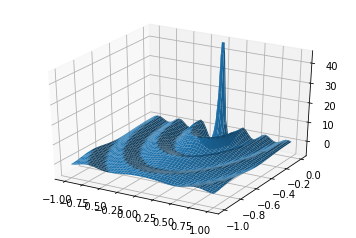

In [3]:
r = np.array([X.flatten(), Y.flatten()])
Z = np.real(monopole_r(r).reshape(X.shape))

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.plot_surface(X, Y, Z)
plt.show()

### Regularly spaced, unsorted data: sort parameters and data, meshgrid

Now there is no function. If the data has the form `x`, `y`, `Z[i,j] = f(x[i], y[j])` we can use meshgrid only if the parameter vectors are sorted.

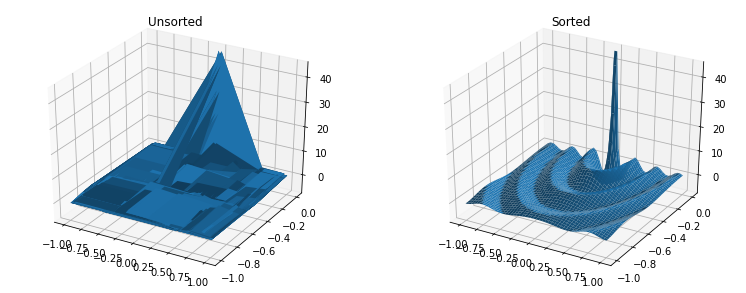

In [4]:
# generate unsorted data (x, y, Z)
np.random.shuffle(x)
np.random.shuffle(y)

X, Y = np.meshgrid(x, y, indexing='ij') 
Z = np.real(monopole(X, Y))

# sort data
ix = np.argsort(x)
iy = np.argsort(y)
x_sort = x[ix]
y_sort = y[iy]
Z_sort = Z[np.ix_(ix, iy)]  # np.ix_ generates an open mesh of the indexes

# use indexing='xy' if data has the form Z[i,j] = f(x[j], y[i])
X_sort, Y_sort = np.meshgrid(x_sort, y_sort, indexing='ij') 

# plot
fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': '3d'}, 
                       figsize=(13,5))
ax[0].plot_surface(X, Y, Z)
ax[0].set_title('Unsorted')
ax[1].plot_surface(X_sort, Y_sort, Z_sort)
ax[1].set_title('Sorted')

plt.show()

### Irregularly spaced data: interpolate on meshgrid

Let's say we have randomly distributed data points `x`, `y`, `z[i] = f(x[i], y[i])`.

In [5]:
n = 1000
x = np.random.uniform(-1, 1, n)
y = np.random.uniform(-1, 0, n)
z = np.zeros(n)
for i in range(n):
    z[i] = np.real(monopole(x[i], y[i]))

If we don't necessarily need a surface plot, one can use `tripcolor` or `tricontourf` that take data as 1D arrays `(x, y, z)` instead of meshgrid form `(X, Y, Z)`.

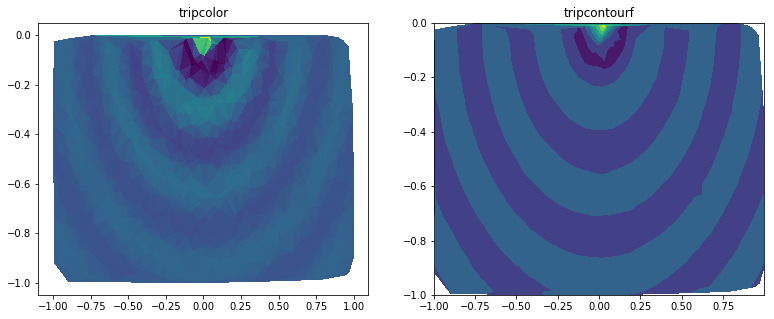

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(13,5))
ax[0].tripcolor(x, y, z)
ax[0].set_title('tripcolor')
ax[1].tricontourf(x, y, z)
ax[1].set_title('tripcontourf');

If we really need a surface plot, we can [interpolate this data on a grid, and then plot the gridded data](http://scipy-cookbook.readthedocs.io/items/Matplotlib_Gridding_irregularly_spaced_data.html).

/home/fmheu/anaconda3/envs/sfcf/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


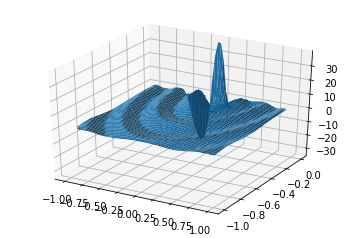

In [7]:
from scipy.interpolate import griddata

# define grid
xg = np.linspace(-1,1,50)
yg = np.linspace(-1,0,100)
Xg, Yg = np.meshgrid(xg, yg)

# grid the data
zg = griddata((x, y), z, (Xg.ravel(), Yg.ravel()), method='cubic')

# reshape into meshgrid size
Zg = zg.reshape(Xg.shape)

# plot
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
ax.plot_surface(Xg, Yg, Zg);

# ignore the warning ...